## Run in google colab
<a href="https://colab.research.google.com/github/lmanov1/HeavyMachineryAuction/blob/main/HeavyMachineryAuction.ipynb" target="_blank">         
<img src="https://colab.research.google.com/assets/colab-badge.svg" 
 target="_blank">
 title="Open this file in Google Colab" alt="Colab"/>
</a>

In [287]:
! pip install gdown
! pip install pandas
! pip install seaborn
! pip install numpy
! pip install matplotlib
! pip install scikit-learn
! pip install pathlib


import gdown
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pathlib import Path

def download_from_gdrive(url, filename):
    # Extract the file ID from the URL
    file_id = url.split('/')[-2]
    download_url = f"https://drive.google.com/uc?id={file_id}"

    # Download the file
    if Path(filename).exists():
        print(f"File '{filename}' already exists. Skipping download.")
    else:
        gdown.download(download_url, filename, quiet=False)
        print(f"File downloaded as: {filename}")

train = 'https://drive.google.com/file/d/1guqSpDv1Q7ZZjSbXMYGbrTvGns0VCyU5/view?usp=drive_link'
valid = 'https://drive.google.com/file/d/1j7x8xhMimKbvW62D-XeDfuRyj9ia636q/view?usp=drive_link'
# Example usage

download_from_gdrive(train, 'train.csv')
download_from_gdrive(valid, 'valid.csv')


20073.55s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable


20080.38s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable


20087.03s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable


20094.32s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable


20101.23s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable


20107.97s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable


20115.00s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
File 'train.csv' already exists. Skipping download.
File 'valid.csv' already exists. Skipping download.


In [306]:
import pandas as pd
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def manipulate_data(df):
    # Make a copy of the dataframe to avoid modifying the original data
    df2 = df.copy()    
    df2['UsageBand'] = df2['UsageBand'].astype('category')
    df2 = pd.get_dummies(df2, columns=['UsageBand'], prefix='UsageBand')
    
    # handle dates in processing
    df2['Saledate'] = pd.to_datetime(df.saledate)
    df2 = df2.select_dtypes(['number', 'datetime','bool'])  # drop all categorical variables
            
    # Feature engineering with dates
    df2['SaleYear'] =  df2['Saledate'].dt.year
    df2['SaleMonth'] =  df2['Saledate'].dt.month     
    # Replace values in YearMade column with YearFromSaledate if YearMade is before 1900 or exceeds the sale date
    df2.loc[(df2['YearMade'] <= 1900) | (df2['YearMade'] > df2['SaleYear']), 'YearMade'] = df2['SaleYear']    
    df2['Age'] = df2['Saledate'].dt.year - df2['YearMade']
    
    # for col in ["YearMade", "Age","SaleYear","SaleMonth"]:
    #     print(f"df2[{col}]: max {df2[col].max():.2f} , min {df2[col].min():.2f} , mean {df2[col].mean():.2f} , std {df2[col].std():.2f},  median {df2[col].median():.2f}")

    # machineid is a unique identifier, so we drop it
    # sale date is redundant now, so we'll drop it
    df2 = df2.drop(columns=['Saledate'])
    df2 = df2.drop(columns=['MachineID'])
    # df2 = df2.drop(columns=['ModelID'])  # don't touch this one !      

    df2 = df2.set_index('SalesID')  # set the index to the unique identifier
    #Remove outliers using 6 sigma method
    for col in df2.select_dtypes(include=[np.number,np.datetime64]).columns:    
        mean = df2[col].mean()       
        df2[col] = df2[col].fillna(mean) # fill missing values with mean         

    # for col in df2.select_dtypes(include=[np.number,np.datetime64]).columns:   # apply filtering only to numerical columns
    #     if col not in ['SalesID', 'SalePrice']:
    #         mean = df2[col].mean()
    #         std_dev = df2[col].std()
    #         median = df2[col].median()
    #         lower_bound = mean - 3 * std_dev
    #         upper_bound = mean + 3 * std_dev

    #         print(f" percent of outliers in {col}: { ((df2[col] < lower_bound) | (df2[col] >= upper_bound)).sum()/df2[col].shape[0]*100:.2f},  min {df2[col].min():.2f}, max {df2[col].max():.2f} , mean {mean:.2f} , std {std_dev:.2f},  median {median:.2f}")
    #         # Normalize the values in place
    #         df2[col] = df2[col].mask(((df2[col] < lower_bound) | (df2[col] > upper_bound)), median)    
    # print ("After 6 sigma filtering ", df2.shape )   
    # values of datasource differ between the train.csv and valid.csv - so we can't use this column's dummies in the model
    # df2['datasource'] = df2['datasource'].astype('category')
    # df2 = pd.get_dummies(df2, columns=['datasource'], prefix='datasource')      
    return df2


### MAIN #########

df = pd.read_csv('train.csv')
# Clean data
print ("Initial ", df.shape)
print("-----------------------------------------------------")
df2 = manipulate_data(df)
print("-----------------------------------------------------")
# print ("Before 6 sigma ", df2.shape )
# #Remove outliers using 6 sigma method
for col in df2.columns:    
    mean = df2[col].mean()
    std_dev = df2[col].std()    
    lower_bound = mean - 3 * std_dev
    upper_bound = mean + 3 * std_dev
    df2 = df2[(df2[col] >= lower_bound) & (df2[col] <= upper_bound)]

df2 = df2.drop_duplicates()  # drop duplicates 

df2 = df2.dropna()  # drop rows with missing values

print("-----------------------------------------------------")
print ("After manipulate_data ", df2.shape )

# Prepare data for training
X = df2.drop(columns='SalePrice')
y = df2['SalePrice']


/tmp/ipykernel_629467/4217917383.py:59: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train.csv')


Initial  (401125, 53)
-----------------------------------------------------
-----------------------------------------------------
-----------------------------------------------------
After manipulate_data  (284199, 12)


In [308]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

RANDOM_STATE = 42
MAX_DEPTH = 20
ESTIMATORS=170
TEST_SIZE=0.2

###################################################    
def train_model(model, X, y, testsize= 0.1 , randomstate = 42 ):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=randomstate)
    
    model.fit(X_train, y_train)
    return X_train, X_test, y_train, y_test

###################################################
def RMSE(y_pred, y_true):
    return ((y_pred - y_true) ** 2).mean() ** 0.5


#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
X_small = X.sample(20000)
y_small = y.loc[X_small.index]

# X_small = X
# y_small = y.loc[X_small.index]

model = RandomForestRegressor(random_state=RANDOM_STATE, max_depth=MAX_DEPTH)
#model = RandomForestRegressor(random_state=RANDOM_STATE)
# Train the model
X_train, X_test, y_train, y_test = train_model(model, X_small, y_small, testsize=TEST_SIZE, randomstate=RANDOM_STATE)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

test_rmse = RMSE(y_test_pred, y_test)
train_rmse = RMSE(y_train_pred, y_train)

print(f" Best test RMSE: {test_rmse:.2f} | y_test.std()={y_test.std():.2f} | y_test.mean()={y_test.mean():.2f} ")
print(f" Best train RMSE: {train_rmse:.2f} | y_train.std()={y_train.std():.2f} | y_train.mean()={y_train.mean():.2f}")

 Best test RMSE: 9948.33 | y_test.std()=20117.38 | y_test.mean()=29559.30 
 Best train RMSE: 3858.92 | y_train.std()=20519.84 | y_train.mean()=29703.41


In [290]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# #print(df2.corr())
# # Create a figure with a custom size
# plt.figure(figsize=(12, 10))  # Adjust figsize to fit your needs
# sns.heatmap(df2.corr(), annot=True, fmt='0.2f')
# plt.show()

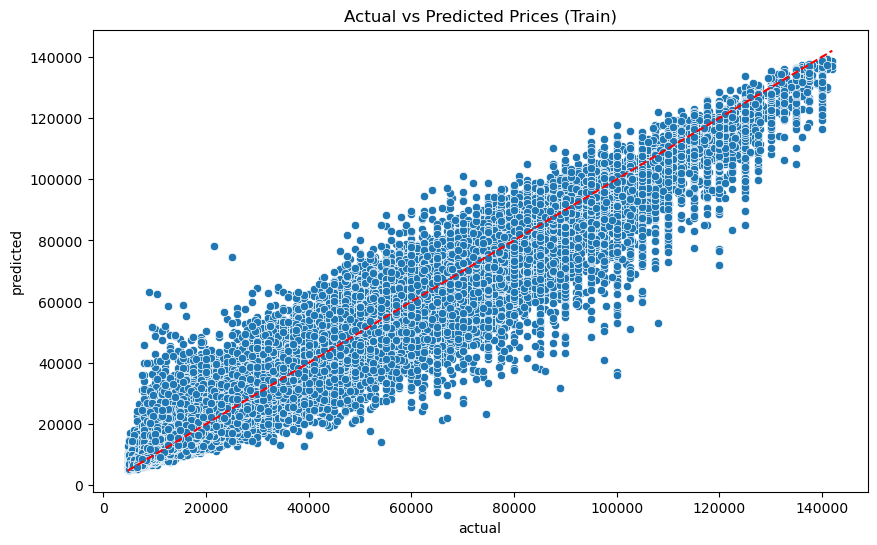

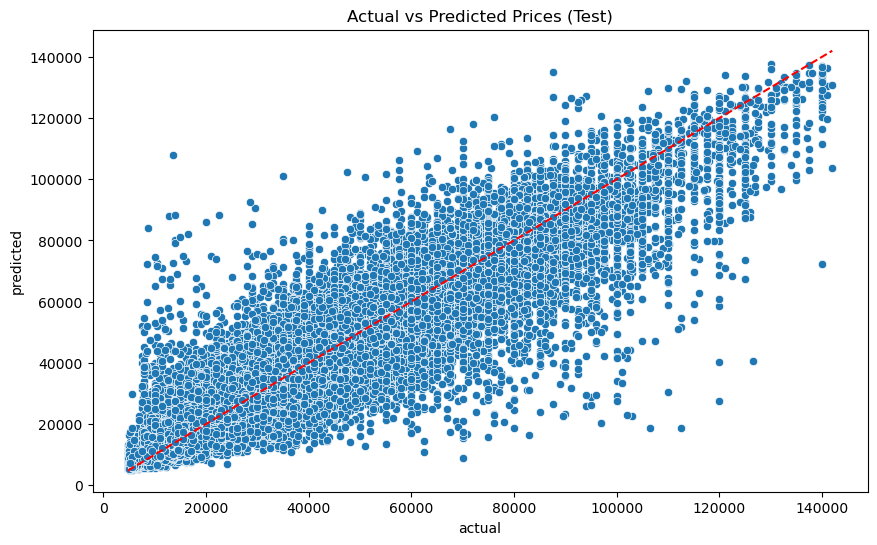

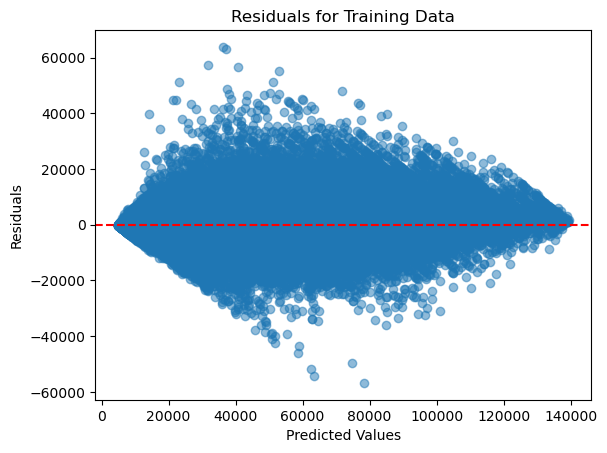

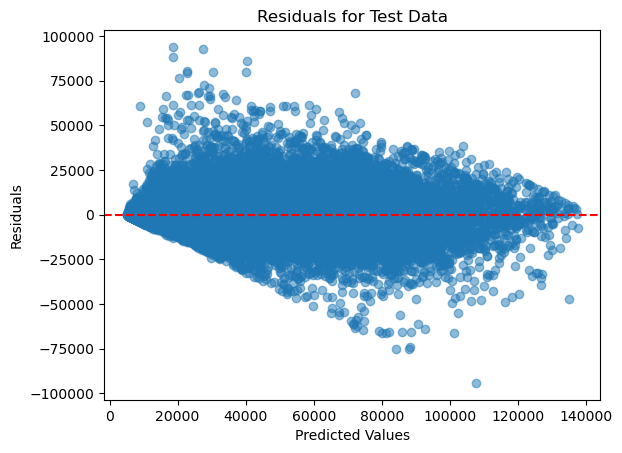

In [291]:
# Predict and analyse the results
# Compute permutation feature importance
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.inspection import permutation_importance

###################################################
def important_features_analysis(model, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1):
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)    

    # Summarize feature importance    
    feature_importances = pd.DataFrame(result.importances_mean, index=X_test.columns, columns=['Permutation Importance'])
    feature_importances['Permutation Importance'] = feature_importances['Permutation Importance'] / feature_importances['Permutation Importance'].sum()
    feature_importances['Feature importance'] = model.feature_importances_
    feature_importances = feature_importances.sort_values(by='Permutation Importance', ascending=False)
    print(feature_importances)

###################################################
def analyse_prediction(model , X_data, y_data , y_pred, random_state=RANDOM_STATE):
    
    print("\n\nRMSE:", round(RMSE(y_pred, y_data),2))
    print("STD", round(y_data.std(),2))
    important_features_analysis(model, X_data, y_data)
   


def plot_prediction(y_data, y_pred, title='Actual vs Predicted Prices'):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_data, y=y_pred)
    xx = np.linspace(y_data.min(), y_data.max(), 100)
    plt.plot(xx, xx, 'r--')
    plt.title(title)
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.show()

###################################################
def predict(model,X_data , y_data=None, random_state=RANDOM_STATE):
    y_pred = model.predict(X_data)
    if y_data is None:
        return y_pred
    
    #analyse_prediction(model, X_data , y_data , y_pred, random_state=random_state)    
    return y_pred
###################################################
def summary(model,X_train, X_test, y_train, y_test, random_state=RANDOM_STATE):
    
    y_train_pred = predict(model,X_train, y_train,random_state=random_state)
    y_test_pred = predict(model,X_test, y_test,random_state=random_state)   
    
    plot_prediction(y_train, y_train_pred,"Actual vs Predicted Prices (Train)")
     
    plot_prediction(y_test, y_test_pred,"Actual vs Predicted Prices (Test)")
   
    return y_train_pred, y_test_pred

###################################################
def summary2(model,X_train, X_test, y_train, y_test, random_state=RANDOM_STATE):
    
    y_train_pred, y_test_pred = summary(model, X_train, X_test, y_train, y_test, random_state=random_state)
    return y_train_pred, y_test_pred
    
###################################################
def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.title(title)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()

###############################################################
# Assuming the summary function is defined as in the provided code snippet
def summary_with_residuals(model, X_train, X_test, y_train, y_test, random_state):
    y_train_pred, y_test_pred = summary(model, X_train, X_test, y_train, y_test, random_state=random_state)
    
    # Plotting residuals for training data
    plot_residuals(y_train, y_train_pred, "Residuals for Training Data")
    
    # Plotting residuals for test data
    plot_residuals(y_test, y_test_pred, "Residuals for Test Data")


# ---------------------------------------------------------------------------------
# Call the modified summary function with residuals plotting
summary_with_residuals(model, X_train, X_test, y_train, y_test, random_state=RANDOM_STATE)

In [304]:
# Predict on the validation set
X_valid = pd.read_csv('valid.csv')
print ("Initial ", X_valid.shape)

print("-----------------------------------------------------")
X_valid = manipulate_data(X_valid)
print("-----------------------------------------------------")
print ("After manipulate_data ", X_valid.shape )
print("-----------------------------------------------------")
#print(X_valid.head())
y_valid_pred = predict(model, X_valid, random_state=RANDOM_STATE)  # predict on the validation set               
y_valid_pred = pd.Series(y_valid_pred, index=X_valid.index, name='SalePrice')
y_valid_pred.info()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        


Initial  (11573, 52)
-----------------------------------------------------
-----------------------------------------------------
After manipulate_data  (11573, 11)
-----------------------------------------------------
<class 'pandas.core.series.Series'>
Index: 11573 entries, 1222837 to 6333349
Series name: SalePrice
Non-Null Count  Dtype  
--------------  -----  
11573 non-null  float64
dtypes: float64(1)
memory usage: 180.8 KB


In [303]:
from datetime import datetime

f'submission_{datetime.now().isoformat()}'
y_valid_pred.to_csv(f'submission_{datetime.now().isoformat()}.csv')
